In [1]:
import findspark
findspark.init()
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col, count, when, isnan

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import random
import matplotlib.pyplot as plt
import seaborn as sns

## Step 0 :  Spark session and spark context initialisation 

In [2]:
spark = SparkSession.builder \
    .appName("Bank Marketing") \
    .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [3]:
print(spark.version)

3.5.1


## Step 1 : Initialization and data ingestion 

In [4]:
file_path = "bank-additional-full.csv"

# Read CSV file into DataFrame
df = spark.read.option("delimiter", ";").option("header", True).csv(file_path, inferSchema=True)

# Show the content of the DataFrame
df.show(n=5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

## Step 2 : Exploration data analysis & Transformation

In [5]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



In [6]:
#We could observe that there are some column in the dataset that has . in them thus could induce errors when running the code 
# Thus let's replace those "." by "_"

columns_containing_dots = [col_name for col_name in df.columns if '.' in col_name]

# Rename columns with dots
for col_name in columns_containing_dots:
    new_col_name = col_name.replace('.', '_')  # Replace dots with underscores
    df = df.withColumnRenamed(col_name, new_col_name)

df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



In [7]:
# let's check if there is any null value in the dataste
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



In [8]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

In [9]:
#we could observe from the result that the dataset does not have any nan value., so let's check the distribution of the data
df.select(numeric_columns).describe()#.show(vertical=True)

summary,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
mean,40.02406040594348,258.2850101971448,2.567592502670681,962.4754540157328,0.17296299893172767,0.08188550063178392,93.57566436828918,-40.50260027191787,3.6212908128585366,5167.035910944004
stddev,10.421249980934057,259.27924883646455,2.770013542902331,186.9109073447414,0.49490107983928927,1.57095974051703,0.5788400489541355,4.628197856174595,1.7344474048512557,72.25152766825924
min,17,0,1,0,0,-3.4,92.201,-50.8,0.634,4963.6
max,98,4918,56,999,7,1.4,94.767,-26.9,5.045,5228.1


we could observe the negative values on emp_var_rate and cons_conf_idx and it is normal as these indicators reflect fluctuations in employment levels and consumer sentiment, respectively, within the context of broader economic conditions.

<Figure size 800x600 with 0 Axes>

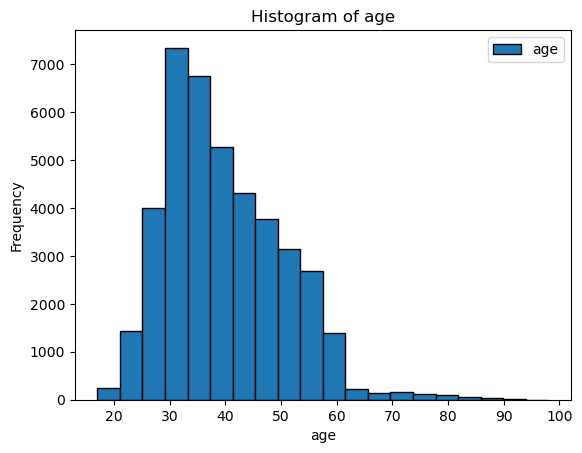

<Figure size 800x600 with 0 Axes>

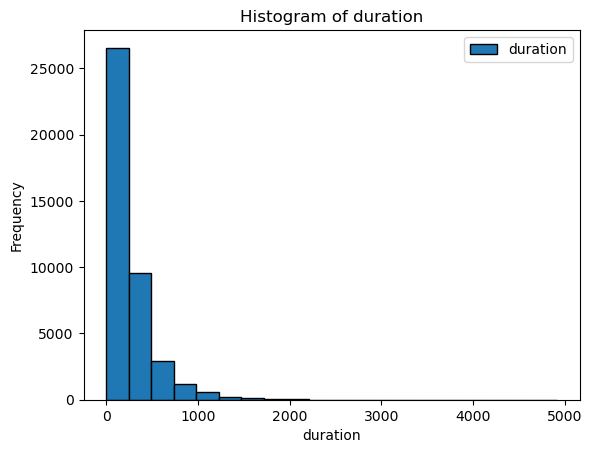

<Figure size 800x600 with 0 Axes>

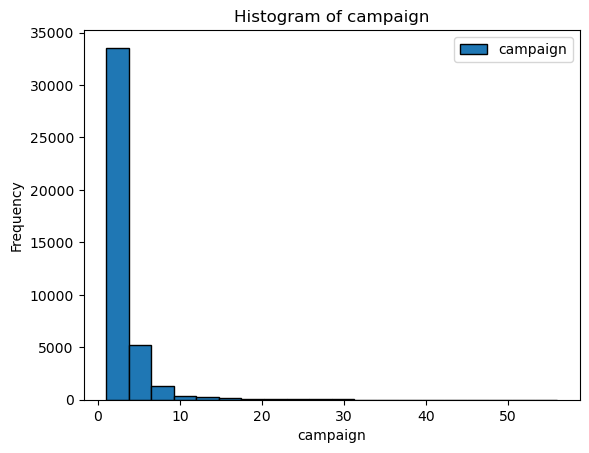

<Figure size 800x600 with 0 Axes>

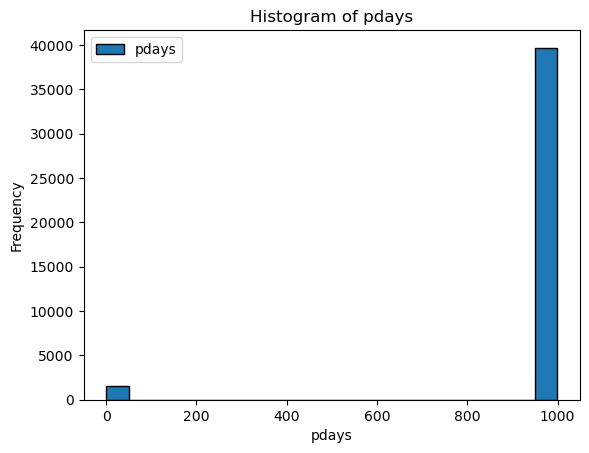

<Figure size 800x600 with 0 Axes>

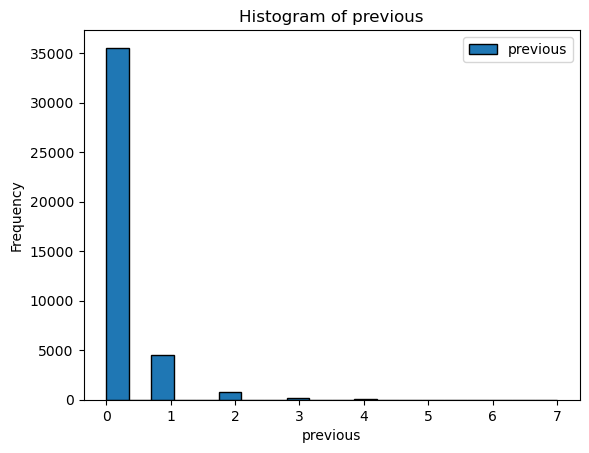

<Figure size 800x600 with 0 Axes>

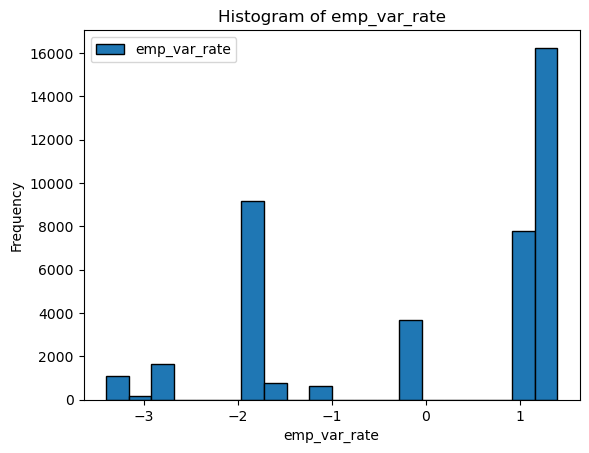

<Figure size 800x600 with 0 Axes>

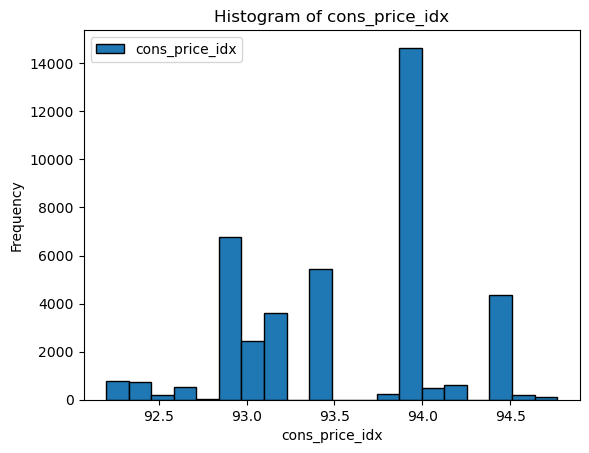

<Figure size 800x600 with 0 Axes>

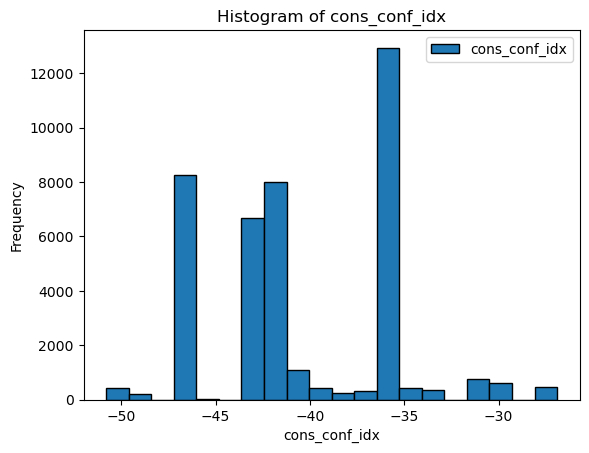

<Figure size 800x600 with 0 Axes>

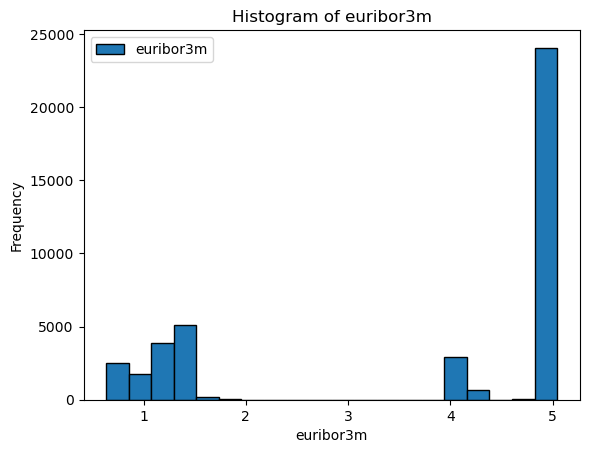

<Figure size 800x600 with 0 Axes>

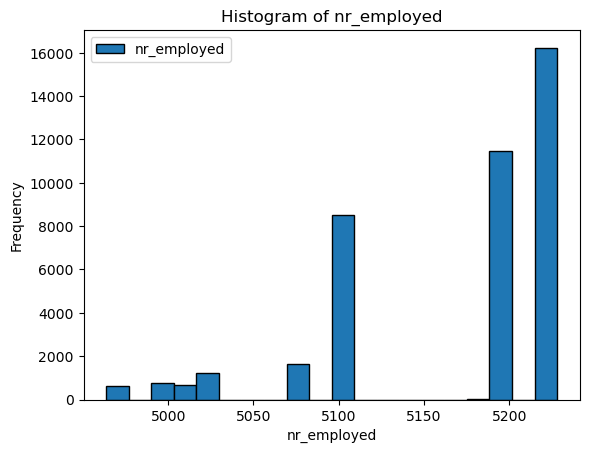

In [10]:
# let's explore the distribution of those numerical values on a plot and also the categorical ones

def plot_numeric_histogram(column):
    plt.figure(figsize=(8, 6))
    df.select(column).toPandas().plot(kind='hist', bins=20, edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.show()

# Plot histograms for numeric columns
for column in numeric_columns:
    plot_numeric_histogram(column)



### From the plots above, we can observe that :
- **Age Distribution:** People between 30-40 years old were the most called.
- **Average Contact Duration:** Most marketing-goal contacts lasted for roughly 250 seconds.
- **Frequency of Contact:** During marketing, clients were typically contacted once.
- **Time Since Last Campaign:** Most clients were contacted almost 3 years after a previous campaign.
- **Outcome of Last Campaign:** The majority of clients were not contacted during the last campaign, with only a few (almost 5000 persons) contacted once.
- **nr_employed:** More than 16,000 instances have `nr_employed` values greater than 5,200, suggesting a significant portion of the dataset reflects periods with relatively higher levels of employment, which is also explained by `emp_var_rate`.
- **Consumer Behavior:** As shown by the barplot, consumers tend to be optimistic and spend more, possibly leading to increased spending.
- **cons_price_idx:** The higher value of `cons_price_idx` indicates inflationary pressure and an increase in consumer prices.
- **euribor3m:** `euribor3m`, which represents the average interest rate at which European banks lend to each other for a three-month period, shows relative stability.


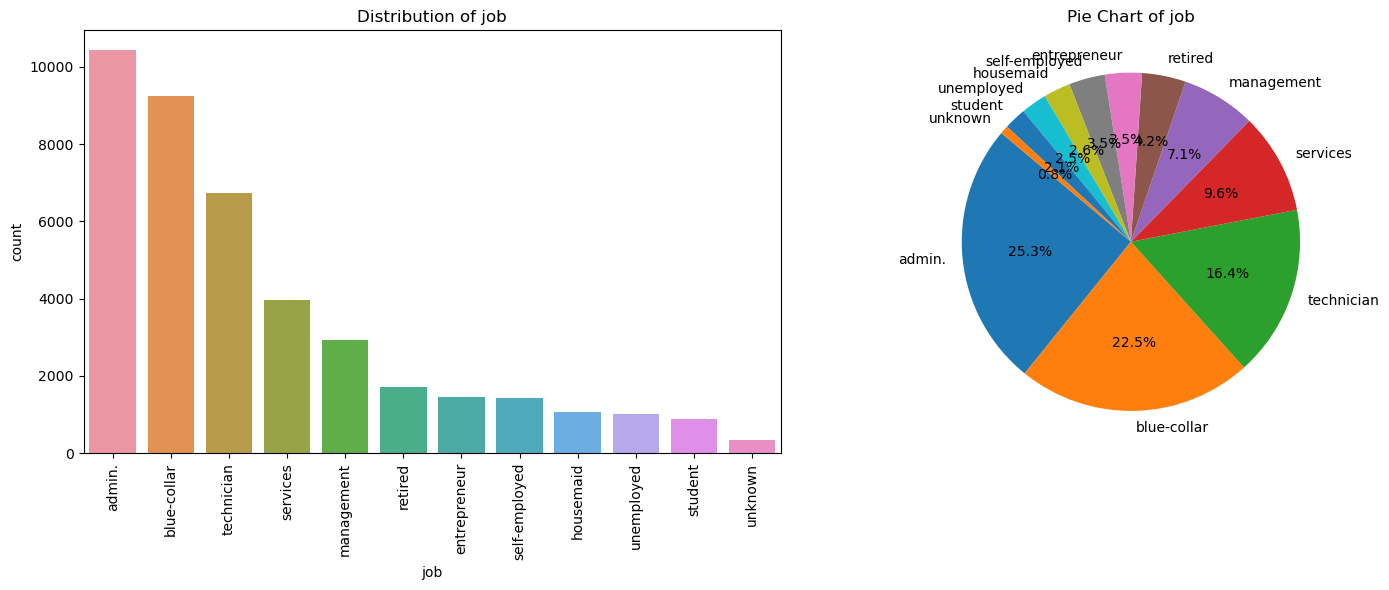

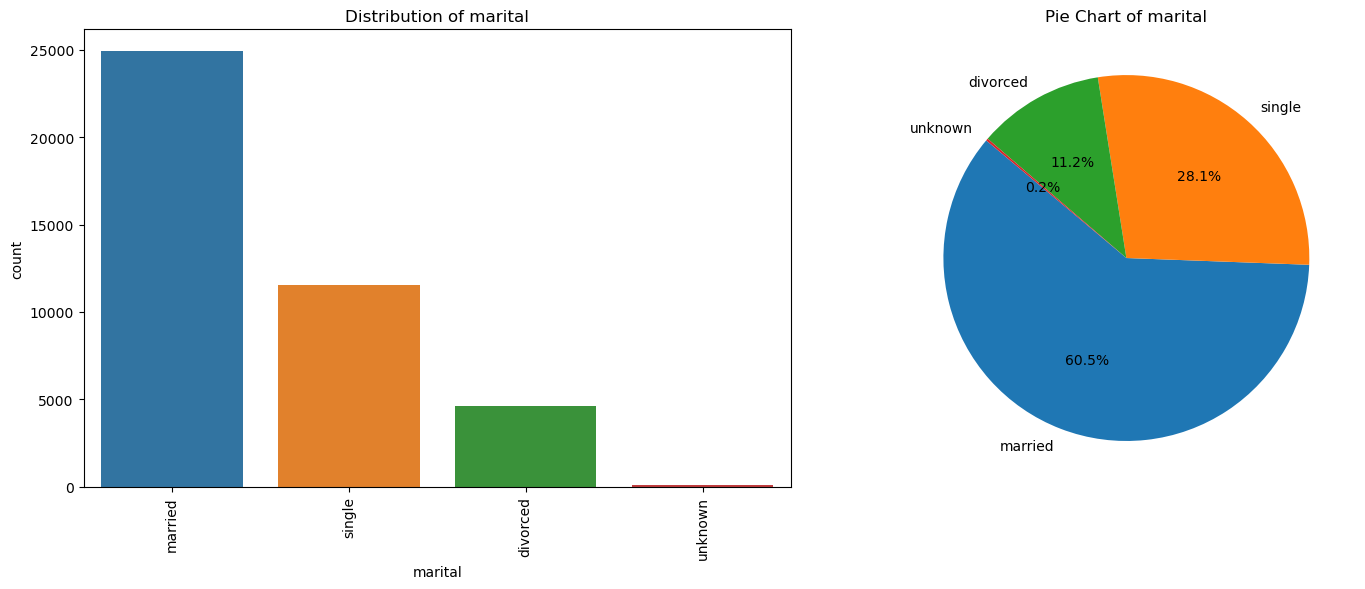

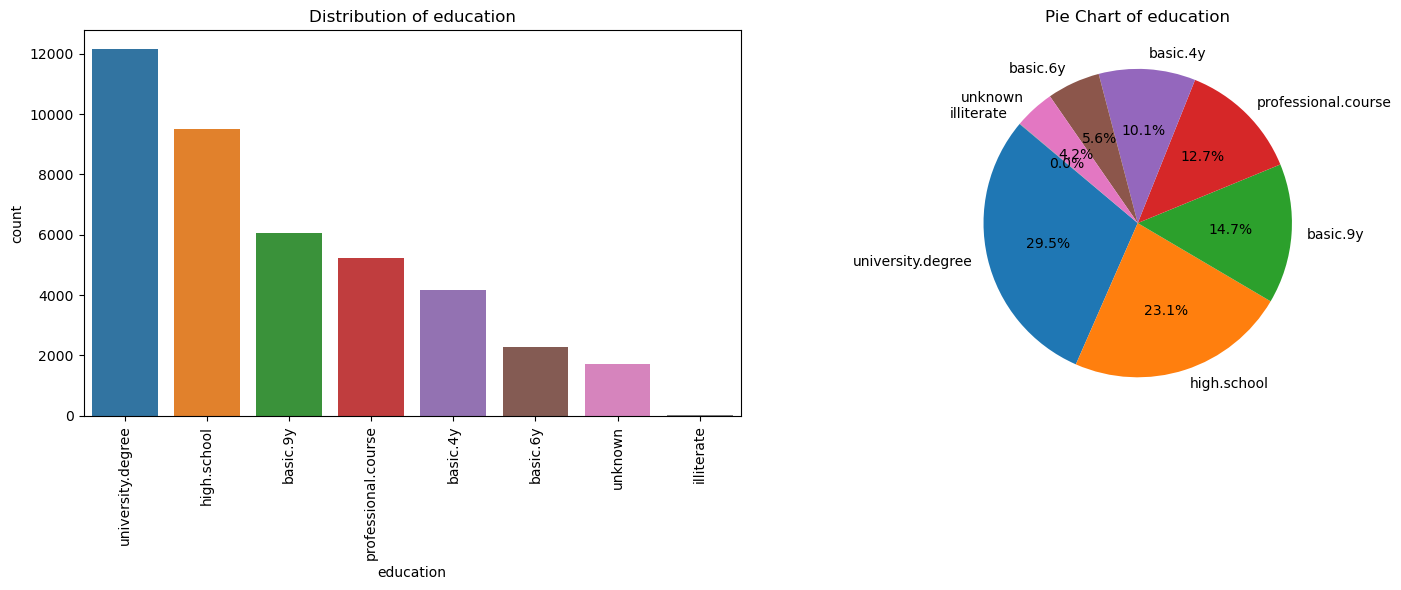

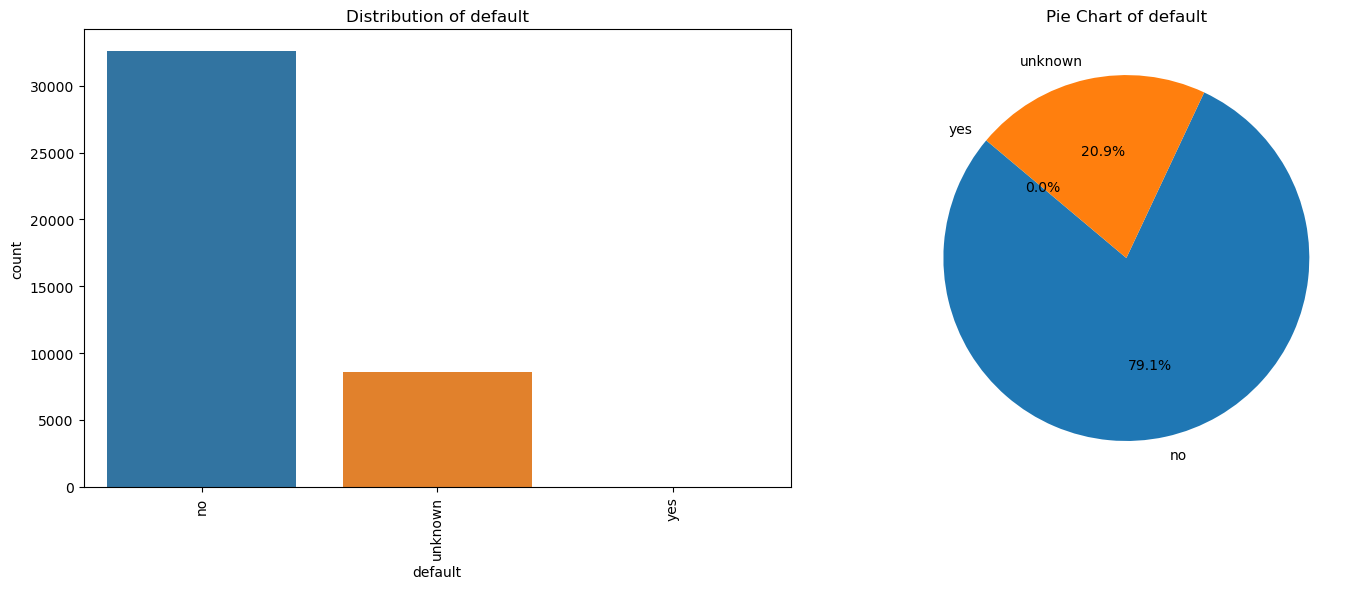

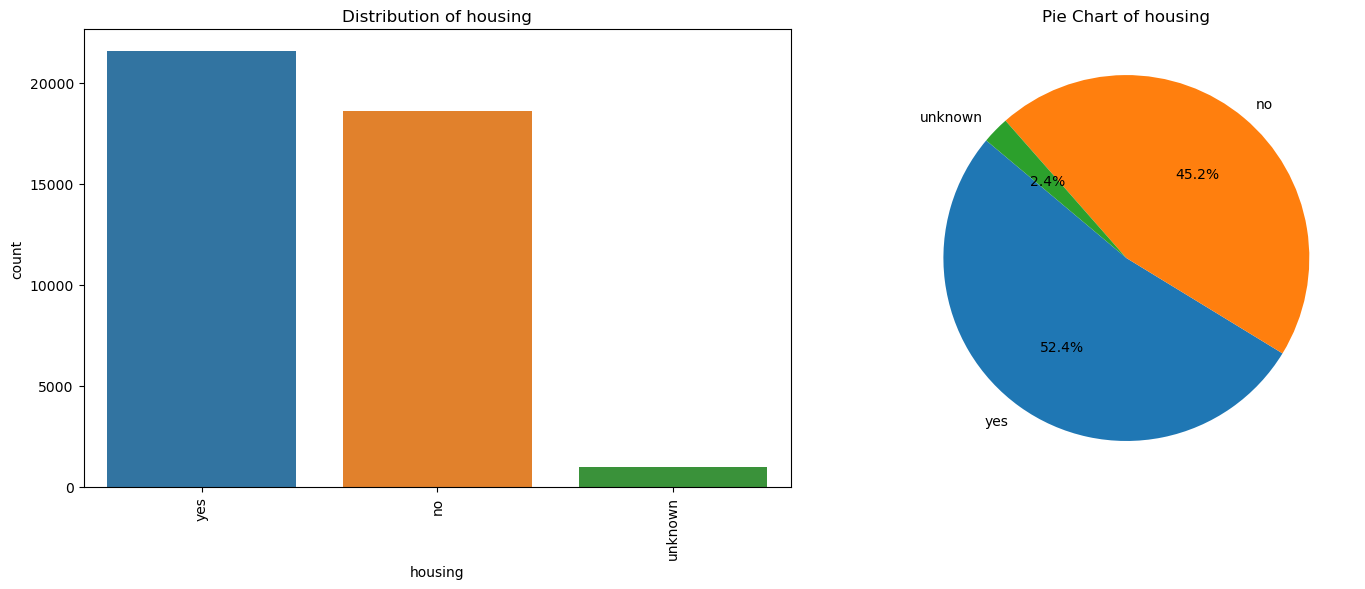

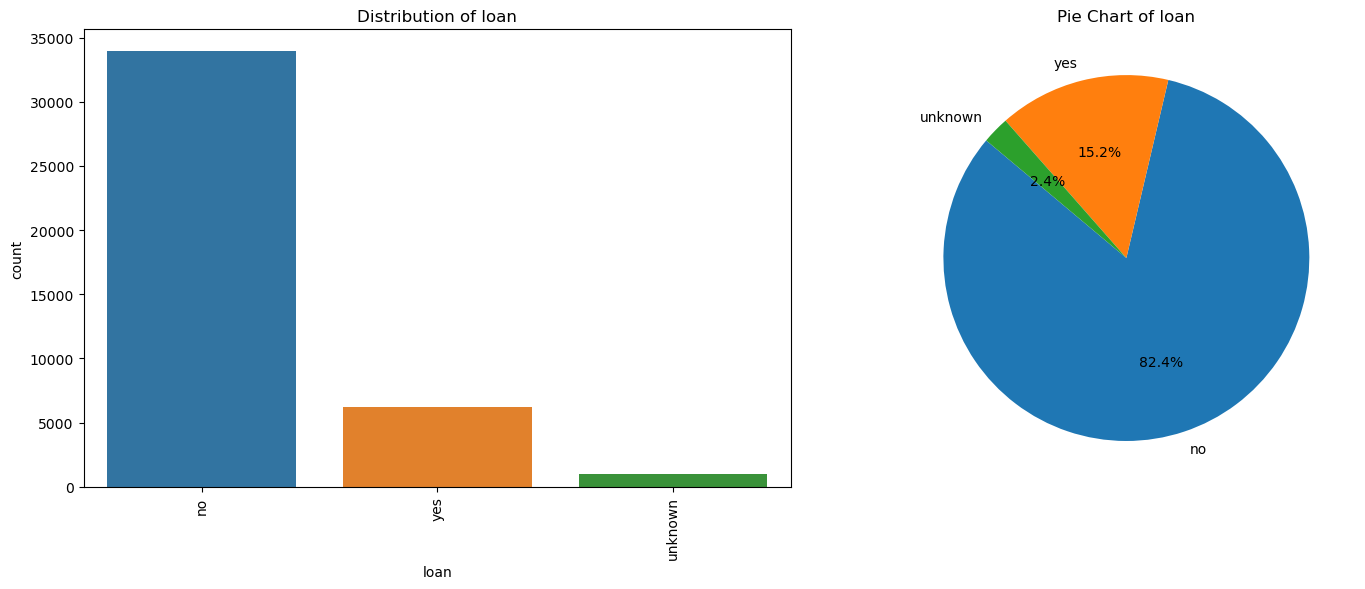

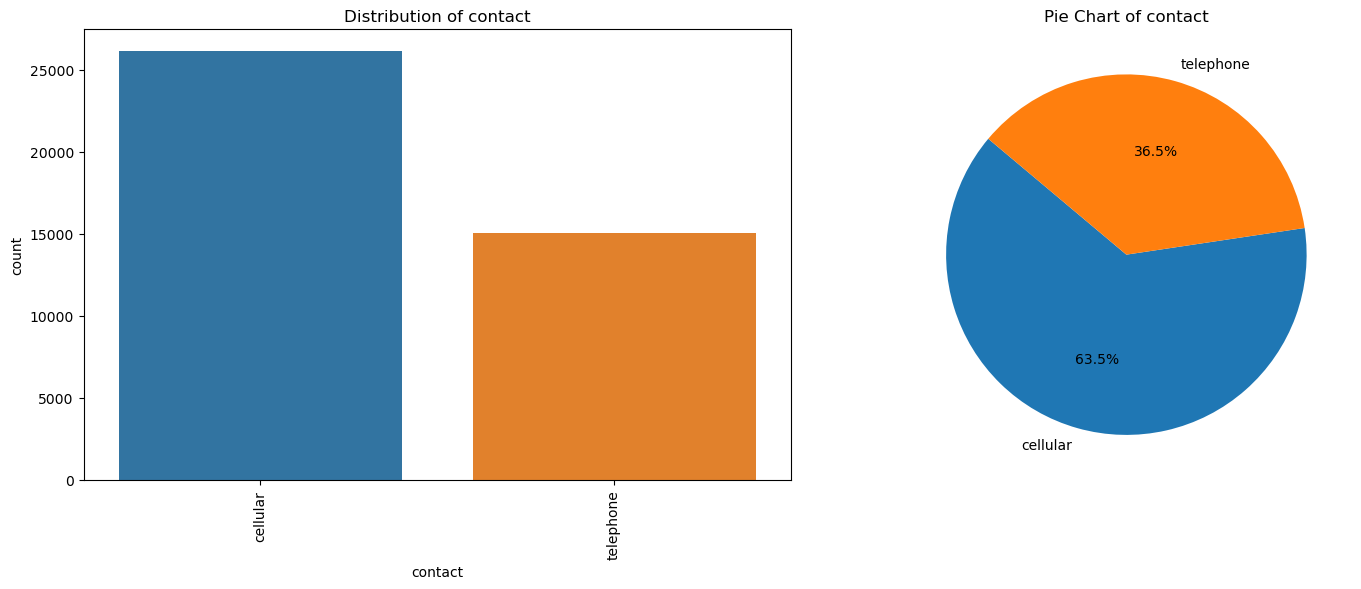

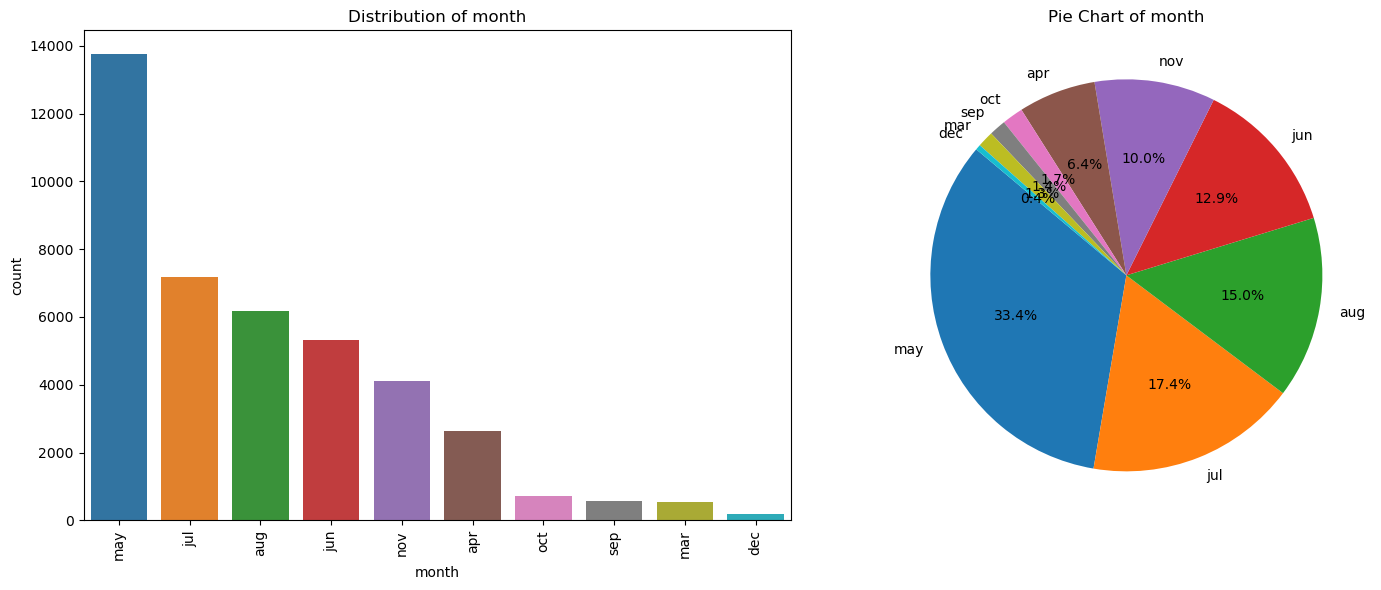

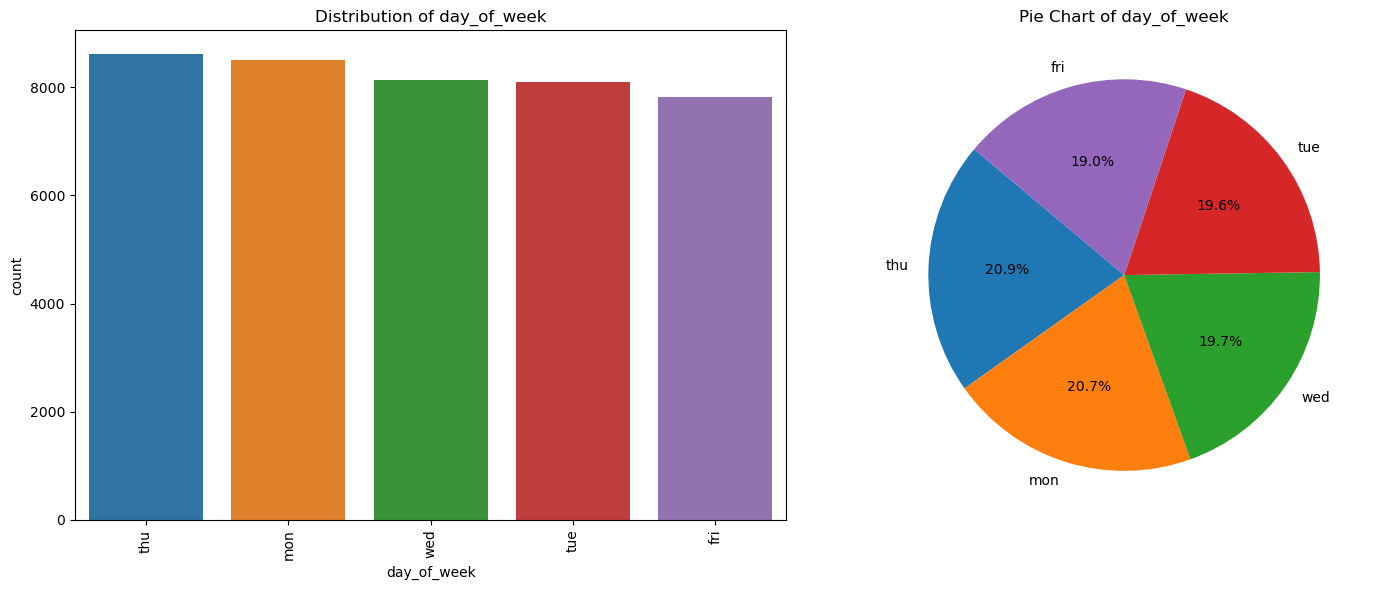

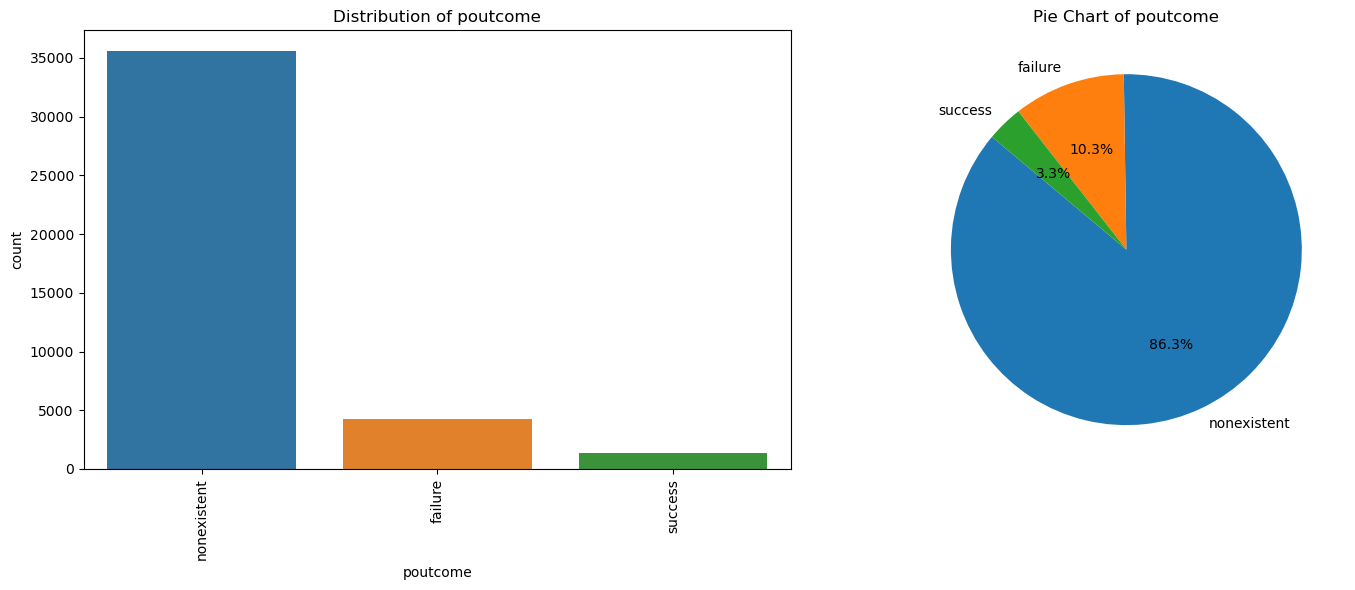

In [11]:
def plot_categorical_distribution(column):
    distribution = df.groupBy(column).count().orderBy(col("count").desc())
    distribution = distribution.toPandas()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column, y='count', data=distribution)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=90)
    plt.show()

def plot_categorical_distribution(column):
    # Calculate distribution of values
    distribution = df.groupBy(column).count().orderBy(col("count").desc())
    distribution = distribution.toPandas()
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Create subplots with 1 row and 2 columns
    
    # Bar plot
    sns.barplot(x=column, y='count', data=distribution, ax=ax1)
    ax1.set_title(f'Distribution of {column}')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90) 
    
    # Pie chart
    labels = distribution[column]
    sizes = distribution['count']
    ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    ax2.set_title(f'Pie Chart of {column}')
    
    plt.tight_layout() 
    plt.show()
    
# Plot distributions for categorical columns
for column in categorical_columns:
    plot_categorical_distribution(column)

### We could oberve that : 

- **job:** Most of the consumers involved in the research were admins, with few being students or unemployed.
- **marital:** The majority of consumers were married.
- **education:** Most of the users called had a university degree or high school diploma.
- **default:** The consumers called didn't have personal credit defaults.
- **housing:** Most of the consumers called were on a housing loan.
- **loan:** The majority of the consumers called did not have any personal loans.
- **contact:** Most calls were directed towards cellular users.
- **month:** Most marketing efforts occurred in May, possibly due to events like Mother's Day or regular work days.
- **day_of_week:** The most marketing calls happened on Mondays and Thursdays.
- **poutcome:** Although most customers weren't contacted before (86%), there were more failures in attempts than sour analysis.

## Step 3 :  Loading data 

In [12]:
# Save the transformed data as parquet for data exploration in PowerBI
#df.write.mode('overwrite').csv("transformed_bank_marketing_data.csv", header=True)
# the data were saved in parquet to facilitate data querying
df.write.mode('overwrite').parquet("transformed_bank_marketing_data.parquet")

## Step 4 :  Machine learning modelling to see if the result of a marketing call could be successful or not

In [13]:
# Since there is no null, let's transform categorical columns to numeric
df = df.withColumn("default", when(col("default") == "yes", 1).otherwise(0)) \
       .withColumn("housing", when(col("housing") == "yes", 1).otherwise(0)) \
       .withColumn("loan", when(col("loan") == "yes", 1).otherwise(0)) \
       .withColumn("y", when(col("y") == "yes", 1).otherwise(0))

df.show(5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|      0|      0|   0|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|  0|
| 57| services|married|high.school|      0|      0|   0|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|  0|
| 37| serv

In [14]:
# Loop through each categorical column and compute value counts
for col_name in categorical_columns:
    value_counts = df.groupBy(col_name).agg(count("*").alias("count")).collect()
    # Print or further process the value counts
    print(f"Value counts for {col_name}:")
    for row in value_counts:
        print(f"{row[col_name]}: {row['count']}")
    print("\n")   

Value counts for job:
management: 2924
retired: 1720
unknown: 330
self-employed: 1421
student: 875
blue-collar: 9254
entrepreneur: 1456
admin.: 10422
technician: 6743
services: 3969
housemaid: 1060
unemployed: 1014


Value counts for marital:
unknown: 80
divorced: 4612
married: 24928
single: 11568


Value counts for education:
high.school: 9515
unknown: 1731
basic.6y: 2292
professional.course: 5243
university.degree: 12168
illiterate: 18
basic.4y: 4176
basic.9y: 6045


Value counts for default:
1: 3
0: 41185


Value counts for housing:
1: 21576
0: 19612


Value counts for loan:
1: 6248
0: 34940


Value counts for contact:
cellular: 26144
telephone: 15044


Value counts for month:
jun: 5318
aug: 6178
may: 13769
mar: 546
oct: 718
jul: 7174
nov: 4101
apr: 2632
dec: 182
sep: 570


Value counts for day_of_week:
fri: 7827
thu: 8623
tue: 8090
wed: 8134
mon: 8514


Value counts for poutcome:
success: 1373
failure: 4252
nonexistent: 35563




In [15]:
# Let's get the list of the column and also the count 
print(f'There is a total of {len(df.columns)} columns')
df.printSchema()

There is a total of 21 columns
root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: integer (nullable = false)
 |-- housing: integer (nullable = false)
 |-- loan: integer (nullable = false)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: integer (nullable = false)



In [16]:
#lets run some statistics to check the distribution of the data
#columnList = [item[0] for item in df.dtypes if not item[1].startswith('string')]
df.describe().show(vertical=True)

-RECORD 0------------------------------
 summary        | count                
 age            | 41188                
 job            | 41188                
 marital        | 41188                
 education      | 41188                
 default        | 41188                
 housing        | 41188                
 loan           | 41188                
 contact        | 41188                
 month          | 41188                
 day_of_week    | 41188                
 duration       | 41188                
 campaign       | 41188                
 pdays          | 41188                
 previous       | 41188                
 poutcome       | 41188                
 emp_var_rate   | 41188                
 cons_price_idx | 41188                
 cons_conf_idx  | 41188                
 euribor3m      | 41188                
 nr_employed    | 41188                
 y              | 41188                
-RECORD 1------------------------------
 summary        | mean                 


In [17]:
# it can be seen from that that some  there is no missing value in the dataset they are some anomly. Exemple: min values of  
#categorical_columns = ['age', 'job','marital', 'education', 'default', 'housing', 'loan', 'poutcome' ]

In [18]:
# Group by the target column 'y' to see the distribution
df.groupBy("y").count().show()

+---+-----+
|  y|count|
+---+-----+
|  1| 4640|
|  0|36548|
+---+-----+



In [19]:
# we can observe that the dataset is very unbanlaced (there is more than 10% difference between the two classes)

In [20]:
columns_to_scale = ['job','marital','education','default','housing','contact','month','day_of_week','poutcome']
indexers = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep') for column in columns_to_scale]

indexer_pipeline = Pipeline(stages=indexers).fit(df)

df_transformed = indexer_pipeline.transform(df) 
df_transformed#.select(['job','marital','marital_index','education','default','housing','contact','month','day_of_week','poutcome'])

age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,job_index,marital_index,education_index,default_index,housing_index,contact_index,month_index,day_of_week_index,poutcome_index
56,housemaid,married,basic.4y,0,0,0,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,8.0,0.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0
57,services,married,high.school,0,0,0,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
37,services,married,high.school,0,1,0,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
40,admin.,married,basic.6y,0,0,0,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0.0,0.0,5.0,0.0,1.0,1.0,0.0,1.0,0.0
56,services,married,high.school,0,0,1,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
45,services,married,basic.9y,0,0,0,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,3.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0
59,admin.,married,professional.course,0,0,0,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0
41,blue-collar,married,unknown,0,0,0,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,6.0,0.0,1.0,1.0,0.0,1.0,0.0
24,technician,single,professional.course,0,1,0,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0
25,services,single,high.school,0,1,0,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [21]:
df_transformed = df_transformed.drop(*columns_to_scale)
for column in columns_to_scale:
    df_transformed  = df_transformed.withColumnRenamed(column+'_index', column) 
df_transformed

age,loan,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,job,marital,education,default,housing,contact,month,day_of_week,poutcome
56,0,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,8.0,0.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0
57,0,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
37,0,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
40,0,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0.0,0.0,5.0,0.0,1.0,1.0,0.0,1.0,0.0
56,1,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
45,0,198,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,3.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0
59,0,139,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0
41,0,217,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,6.0,0.0,1.0,1.0,0.0,1.0,0.0
24,0,380,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,2.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0
25,0,50,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [22]:
df_transformed.printSchema()

root
 |-- age: integer (nullable = true)
 |-- loan: integer (nullable = false)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: integer (nullable = false)
 |-- job: double (nullable = false)
 |-- marital: double (nullable = false)
 |-- education: double (nullable = false)
 |-- default: double (nullable = false)
 |-- housing: double (nullable = false)
 |-- contact: double (nullable = false)
 |-- month: double (nullable = false)
 |-- day_of_week: double (nullable = false)
 |-- poutcome: double (nullable = false)



In [23]:
# Split data into training and test sets
train_data, test_data = df_transformed.randomSplit([0.8, 0.2])

In [24]:
train_data.show(5)

+---+----+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+----+-------+---------+-------+-------+-------+-----+-----------+--------+
|age|loan|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y| job|marital|education|default|housing|contact|month|day_of_week|poutcome|
+---+----+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+----+-------+---------+-------+-------+-------+-----+-----------+--------+
| 18|   0|      75|       1|  999|       0|        -0.1|          93.2|        -42.0|    4.245|     5195.8|  0|10.0|    1.0|      1.0|    0.0|    1.0|    1.0|  4.0|        0.0|     0.0|
| 18|   1|     103|       1|  999|       0|        -1.8|        92.843|        -50.0|    1.687|     5099.1|  0|10.0|    1.0|      1.0|    0.0|    0.0|    0.0|  8.0|        3.0|     0.0|
| 19|   0|      43|       3|  999|       0|        -1.8|        93.075

In [25]:
test_data.show(5)

+---+----+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+----+-------+---------+-------+-------+-------+-----+-----------+--------+
|age|loan|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y| job|marital|education|default|housing|contact|month|day_of_week|poutcome|
+---+----+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+----+-------+---------+-------+-------+-------+-----+-----------+--------+
| 19|   0|     108|       5|  999|       0|        -1.8|        93.075|        -47.1|    1.405|     5099.1|  0|10.0|    1.0|      6.0|    0.0|    1.0|    0.0|  5.0|        4.0|     0.0|
| 19|   1|      72|       4|  999|       0|        -1.8|        93.075|        -47.1|    1.405|     5099.1|  0|10.0|    1.0|      6.0|    0.0|    0.0|    0.0|  5.0|        4.0|     0.0|
| 20|   0|      97|      15|  999|       0|         1.4|        93.918

In [26]:
# Assemble features
assembler = VectorAssembler(
    inputCols=[col for col in train_data.columns if col != "y"],
    outputCol="features"
)
train_data_scaled = assembler.transform(train_data)
train_data_scaled

age,loan,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,job,marital,education,default,housing,contact,month,day_of_week,poutcome,features
18,0,75,1,999,0,-0.1,93.2,-42.0,4.245,5195.8,0,10.0,1.0,1.0,0.0,1.0,1.0,4.0,0.0,0.0,"[18.0,0.0,75.0,1...."
18,1,103,1,999,0,-1.8,92.843,-50.0,1.687,5099.1,0,10.0,1.0,1.0,0.0,0.0,0.0,8.0,3.0,0.0,"[18.0,1.0,103.0,1..."
19,0,43,3,999,0,-1.8,93.075,-47.1,1.453,5099.1,0,10.0,1.0,2.0,0.0,1.0,0.0,5.0,3.0,0.0,"[19.0,0.0,43.0,3...."
19,0,87,4,999,0,1.4,93.918,-42.7,4.96,5228.1,0,10.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,"[19.0,0.0,87.0,4...."
19,0,126,4,999,0,-1.8,92.843,-50.0,1.64,5099.1,1,10.0,1.0,2.0,0.0,0.0,0.0,8.0,4.0,0.0,"[19.0,0.0,126.0,4..."
19,0,136,1,999,0,-1.8,92.843,-50.0,1.556,5099.1,1,10.0,1.0,5.0,0.0,1.0,0.0,8.0,3.0,0.0,"[19.0,0.0,136.0,1..."
19,0,156,1,999,0,-1.8,93.075,-47.1,1.405,5099.1,1,10.0,1.0,6.0,0.0,0.0,0.0,5.0,4.0,0.0,"[19.0,0.0,156.0,1..."
19,0,165,3,999,0,-1.8,93.075,-47.1,1.41,5099.1,0,10.0,1.0,2.0,0.0,1.0,0.0,5.0,0.0,0.0,"[19.0,0.0,165.0,3..."
19,0,299,1,999,0,-1.8,93.075,-47.1,1.453,5099.1,1,10.0,1.0,2.0,0.0,0.0,0.0,5.0,3.0,0.0,"[19.0,0.0,299.0,1..."
19,0,438,1,999,0,-1.8,93.075,-47.1,1.405,5099.1,1,10.0,1.0,6.0,0.0,0.0,0.0,5.0,1.0,0.0,"[19.0,0.0,438.0,1..."


In [27]:
#check the features that influence the decision the most

rf = RandomForestClassifier(featuresCol='features', labelCol='y', numTrees=10)
model_rf = rf.fit(train_data_scaled)

# Extract feature importances
feature_importances = model_rf.featureImportances

feature_cols = assembler.getInputCols()
importance_with_names = [(importance, feature_cols[index]) for index, importance in enumerate(feature_importances)]

# Sort tuples by importance (descending)
importance_with_names_sorted = sorted(importance_with_names, key=lambda x: x[0], reverse=True)

# Print feature importance in descending order
print("Feature Importance (Descending Order):")
print('=======================================')
for importance, column_name in importance_with_names_sorted:
    print(f"{column_name}: {importance:.4f}")

Feature Importance (Descending Order):
duration: 0.3497
nr_employed: 0.2315
euribor3m: 0.1884
pdays: 0.1024
cons_conf_idx: 0.0416
emp_var_rate: 0.0255
month: 0.0150
contact: 0.0108
poutcome: 0.0103
cons_price_idx: 0.0101
job: 0.0043
day_of_week: 0.0034
previous: 0.0033
campaign: 0.0015
age: 0.0011
education: 0.0007
housing: 0.0002
loan: 0.0001
marital: 0.0001
default: 0.0000


In [28]:
# Create a logistic regression model
lr = LogisticRegression(labelCol="y", featuresCol="features")
model = lr.fit(train_data_scaled)

In [29]:
test_data = assembler.transform(test_data)
test_data.show(5)

+---+----+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+----+-------+---------+-------+-------+-------+-----+-----------+--------+--------------------+
|age|loan|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y| job|marital|education|default|housing|contact|month|day_of_week|poutcome|            features|
+---+----+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+----+-------+---------+-------+-------+-------+-----+-----------+--------+--------------------+
| 19|   0|     108|       5|  999|       0|        -1.8|        93.075|        -47.1|    1.405|     5099.1|  0|10.0|    1.0|      6.0|    0.0|    1.0|    0.0|  5.0|        4.0|     0.0|[19.0,0.0,108.0,5...|
| 19|   1|      72|       4|  999|       0|        -1.8|        93.075|        -47.1|    1.405|     5099.1|  0|10.0|    1.0|      6.0|    0.0|    0.0|    0.0|  5.0|        

In [30]:
# Make predictions
predictions = model.transform(test_data)
predictions.show(n=10)

+---+----+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+----+-------+---------+-------+-------+-------+-----+-----------+--------+--------------------+--------------------+--------------------+----------+
|age|loan|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y| job|marital|education|default|housing|contact|month|day_of_week|poutcome|            features|       rawPrediction|         probability|prediction|
+---+----+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+----+-------+---------+-------+-------+-------+-----+-----------+--------+--------------------+--------------------+--------------------+----------+
| 19|   0|     108|       5|  999|       0|        -1.8|        93.075|        -47.1|    1.405|     5099.1|  0|10.0|    1.0|      6.0|    0.0|    1.0|    0.0|  5.0|        4.0|     0.0|[19.0,0.0,108.0,5...|[2.49649760764

In [33]:
df.groupby(df.y).count().show()

+---+-----+
|  y|count|
+---+-----+
|  1| 4640|
|  0|36548|
+---+-----+



In [31]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="y", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print(f"Accuracy: {f1_score}")

Accuracy: 0.8980485671458407


In [32]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="y")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9300573875221612


In [34]:
preds_and_labels = predictions.select(['prediction','y']).withColumn('label', F.col('y').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

C:\Users\adnaa\anaconda3\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[7151.  191.]
 [ 563.  348.]]
